In [1]:
import datetime
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Construct the dataset

In [2]:
def downloadData():

    first_date = (datetime.date(2020, 2, 24))
    last_date = (datetime.date(2022, 8, 4))

    for delta in range(1, (last_date - first_date).days):

        today = first_date + datetime.timedelta(days=delta)
        today_url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+today.strftime("%Y%m%d")+'.csv'
        present = pd.read_csv(today_url)
        present.to_csv('date_datasets/'+today.strftime("%Y%m%d")+'.csv', index=False)

In [3]:
#downloadData()

In [4]:
regioni = ["Abruzzo", "Basilicata", "Calabria", "Campania", "Emilia-Romagna", "Friuli-Venezia Giulia", "Lazio", "Liguria", "Lombardia", "Marche", "Molise", "P.A. Bolzano", "P.A. Trento", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "Umbria", "Valle d'Aosta", "Veneto"]
regioni_no_friuli = ["Abruzzo", "Basilicata", "Calabria", "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", "Marche", "Molise", "P.A. Bolzano", "P.A. Trento", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "Umbria", "Valle d'Aosta", "Veneto"]

first_date = (datetime.date(2020, 9, 1))   # perché all'inizio i dati erano sballati
last_date = (datetime.date(2022, 8, 4))

In [5]:
def dateToRegion(regioni, first_date, last_date):

    for regione in regioni_no_friuli:

        regione_csv = pd.DataFrame(data={"perc_story": [], "ospedalizzati_story": []})

        for delta in range(1, (last_date - first_date).days):
            # open the files
            today = first_date + datetime.timedelta(days=delta)
            yesterday = today - datetime.timedelta(days=1)
            present = pd.read_csv('date_datasets/'+today.strftime("%Y%m%d")+'.csv')
            past = pd.read_csv('date_datasets/'+yesterday.strftime("%Y%m%d")+'.csv')
            regione_present = present[ present['denominazione_regione'] == regione ]
            regione_past = past[ past['denominazione_regione'] == regione ]
            # compute the perc
            try:
                tot_tamponi_present = regione_present['tamponi'].values[0]
            except:
                print(regione)
                print(today)
                print(regione_present['tamponi'])
            tot_tamponi_past = regione_past['tamponi'].values[0]
            tamponi_oggi = tot_tamponi_present - tot_tamponi_past
            nuovi_positivi = regione_present['nuovi_positivi'].values[0]
            percentuale = np.around(nuovi_positivi / tamponi_oggi * 100, 2)     # <---
            # compute the hospitalized
            ospedalizzati_attuali = regione_present['totale_ospedalizzati'].values[0]       # <---
            # append the row
            nuova_riga = pd.DataFrame([[percentuale, ospedalizzati_attuali]],
                                        columns=["perc_story", "ospedalizzati_story"])
            regione_csv = pd.concat([regione_csv, nuova_riga])
        
        regione_csv.to_csv(f"region_datasets/{regione}.csv", index=False)

In [6]:
#dateToRegion(regioni_no_friuli, first_date, last_date)

In [7]:
# Plot every columns

# for regione in regioni_no_friuli:
#     df = pd.read_csv(f"region_datasets/{regione}.csv")
#     df.plot(y=['perc_story'], kind="line", figsize=(10, 10), color='red', title=regione)
#     df.plot(y=['ospedalizzati_story'], kind="line", figsize=(10, 10), color='orange', title=regione)

# Preprocess the datasets

## Merge all the datasets and window them

In [8]:
def preprocessDatasets(regions_array, window_length=30, perc_shift=14):
    
    global_dataset = np.empty([0, window_length, 2])
    scaler = MinMaxScaler(feature_range=(0, 1))

    for regione in regions_array:

        dataset = pd.read_csv(f"region_datasets/{regione}.csv").replace([np.inf, -np.inf], np.nan).interpolate()

        perc = dataset['perc_story']
        perc = perc.rolling(window=7, min_periods=1).mean()
        perc = perc.shift(perc_shift).dropna()
        perc = perc.values

        ospedalizzati = dataset['ospedalizzati_story'][perc_shift:].values

        dataset = np.column_stack((ospedalizzati, perc))
        dataset = scaler.fit_transform(dataset)

        indexer = np.arange(window_length)[None, :] + np.arange(dataset.shape[0]-window_length+1)[:, None]
        dataset = dataset[indexer]

        global_dataset = np.vstack((global_dataset, dataset))

    return global_dataset

In [9]:
regioni_no_friuli_no_lomba = ["Abruzzo", "Basilicata", "Calabria", "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Marche", "Molise", "P.A. Bolzano", "P.A. Trento", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "Umbria", "Valle d'Aosta", "Veneto"]

In [10]:
training_set = preprocessDatasets(regioni_no_friuli_no_lomba)

train_input = torch.from_numpy(training_set[:, :-1, :]).type(torch.FloatTensor)
train_target = torch.from_numpy(training_set[:, 1:, 0]).type(torch.FloatTensor)

In [11]:
test_set = preprocessDatasets(["Lombardia"])

test_input = torch.from_numpy(test_set[:, :-1, :]).type(torch.FloatTensor)
test_target = torch.from_numpy(test_set[:, 1:, 0]).type(torch.FloatTensor)

## The network

In [12]:
class LSTM(torch.nn.Module):
    def __init__(self, hidden_neurons=[64, 64]):
        super(LSTM, self).__init__()
        self.hidden_neurons = hidden_neurons
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = torch.nn.LSTMCell(2, self.hidden_neurons[0])
        self.lstm2 = torch.nn.LSTMCell(self.hidden_neurons[0], self.hidden_neurons[1])
        self.linear = torch.nn.Linear(self.hidden_neurons[1], 1)
        
    def forward(self, y, future_preds=0):

        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(num_samples, self.hidden_neurons[0], dtype=torch.float32)
        c_t = torch.zeros(num_samples, self.hidden_neurons[0], dtype=torch.float32)
        h_t2 = torch.zeros(num_samples, self.hidden_neurons[1], dtype=torch.float32)
        c_t2 = torch.zeros(num_samples, self.hidden_neurons[1], dtype=torch.float32)

        for i in range(y.size()[1]):
            h_t, c_t = self.lstm1(y[:, i, :], (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor
        outputs = torch.cat(outputs, dim=1)
        return outputs

## The fit

In [13]:
model = LSTM(hidden_neurons=[32, 32])
criterion = torch.nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=1e-2)

In [14]:
def training_loop(n_epochs, model, optimiser, loss_fn, train_input, train_target, test_input, test_target):

    def closure():
        optimiser.zero_grad()
        out = model(train_input)
        loss = loss_fn(out, train_target)
        loss.backward()
        return loss

    for epoch in range(n_epochs):

        # Train
        optimiser.step(closure)

        # Validate
        with torch.no_grad():
            pred = model(test_input)
            loss_val = loss_fn(pred, test_target)

        # print the loss
        out = model(train_input)
        loss_train = loss_fn(out, train_target)
        print(f"Epoch {epoch+1}, Training loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")

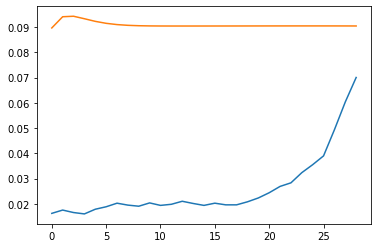

In [15]:
plt.plot(test_target[0], label="target")
plt.plot(model(test_input[:1]).detach()[0], label="prediction")
plt.legend()

Epoch 1, Training loss 0.0002, Validation loss 0.0001


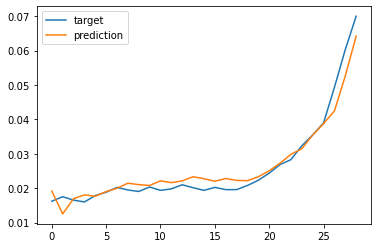

In [18]:
training_loop(1, model, optimiser, criterion, train_input, train_target, test_input, test_target)

plt.plot(test_target[0], label="target")
plt.plot(model(test_input[:1]).detach()[0], label="prediction")
plt.legend()